In [1]:
import math
import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt
import torch.nn as nn

In [2]:
def double_sig_model(xi, theta):
    a1, a2, a3, a4, a5, a6, a7 = theta[0], theta[1], theta[2], theta[3], theta[4], theta[5], theta[6]
    return a1 + (a2-a1)/(1+math.exp(-a3*(xi-a4))) + (a5-a2)/(1+math.exp(-a6*(xi-a7)))

In [3]:
num_points = 250

theta = np.array([0.0, 0.4, 0.15, 50, 1, 0.293, 150])
x = torch.from_numpy(np.arange(num_points)).float()
f = np.array([double_sig_model(xi, theta) for xi in x])
noise = np.random.normal(loc=0, scale=0.1, size=num_points)
y = torch.from_numpy(f + noise).float()

samples = np.random.permutation(num_points)
train_samples = samples[:int(num_points*.8)]
test_samples = samples[int(num_points*.8):]

train_x, train_y, test_x, test_y = x[train_samples], y[train_samples], x[test_samples], y[test_samples]
train_x, train_y = train_x[train_x.argsort()], train_y[train_x.argsort()]
test_x, test_y = test_x[test_x.argsort()], test_y[test_x.argsort()]

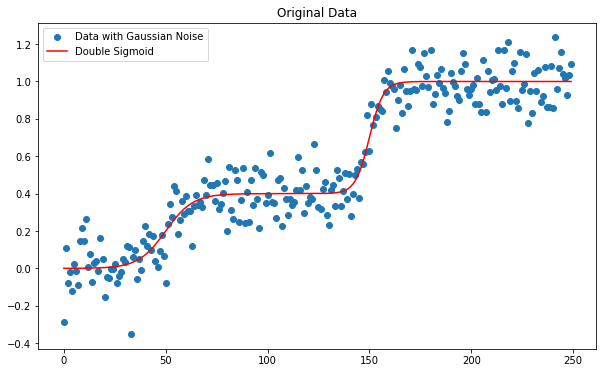

In [4]:
plt.figure(figsize=(10,6))
plt.scatter(x, y, label = 'Data with Gaussian Noise')
plt.plot(f, color = 'red', label = 'Double Sigmoid')
plt.title('Original Data')
plt.legend()
plt.show()

In [5]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


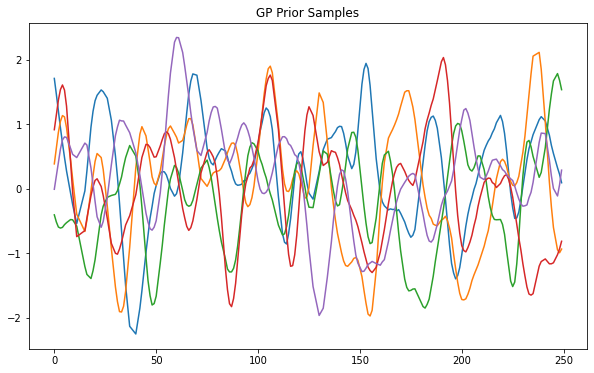

In [6]:
gp = ExactGPModel(
    train_x=x,
    train_y=None,
    likelihood=gpytorch.likelihoods.GaussianLikelihood(),
)

gp.covar_module.base_kernel.lengthscale = 5
gp.eval()

plt.figure(figsize=(10,6))
for i in range(5):
    f_samples = gp(train_x).sample()
    plt.plot(train_x, f_samples.detach())

plt.title('GP Prior Samples')
plt.show()

In [10]:
def plot_preds(model, likelihood): 
    model.eval()
    likelihood.eval()
    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 2, figsize=(20, 6))
        observed_train_pred = likelihood(model(train_x))
        observed_test_pred = likelihood(model(test_x))

        # Get upper and lower confidence bounds
        train_lower, train_upper = observed_train_pred.confidence_region()
        test_lower, test_upper = observed_test_pred.confidence_region()

        # Plot test data as black stars
        ax[0].plot(train_x.numpy(), train_y.numpy(), 'k*')
        ax[1].plot(test_x.numpy(), test_y.numpy(), 'k*')

        # Plot predictive means as blue line
        ax[0].plot(train_x.numpy(), observed_train_pred.mean.numpy(), 'b')
        ax[1].plot(test_x.numpy(), observed_test_pred.mean.numpy(), 'b')

        # Shade between the lower and upper confidence bounds
        ax[0].fill_between(train_x.numpy(), train_lower.numpy(), train_upper.numpy(), alpha=0.5)
        ax[0].legend(['Train Data', 'Mean', '95% Conf. Int.'])
        ax[0].set_ylim([-0.3, 1.3])
        
        ax[1].fill_between(test_x.numpy(), test_lower.numpy(), test_upper.numpy(), alpha=0.5)
        ax[1].legend(['Test Data', 'Mean', '95% Conf. Int.'])
        ax[1].set_ylim([-0.3, 1.3])
        plt.show()
        
        return(observed_train_pred.mean.numpy(), observed_test_pred.mean.numpy())

BEFORE TRAINING
lengthscale: 5.000   noise: 0.693


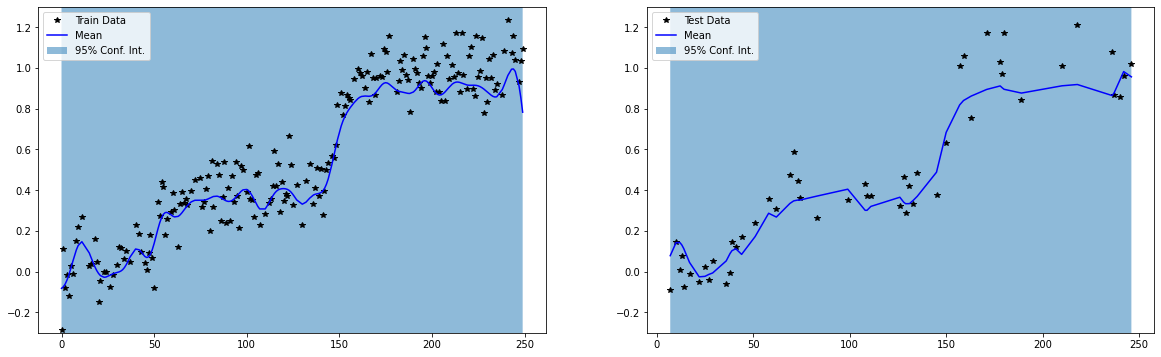

Iter 0/500 - Loss: 0.937   lengthscale: 5.099   noise: 0.644


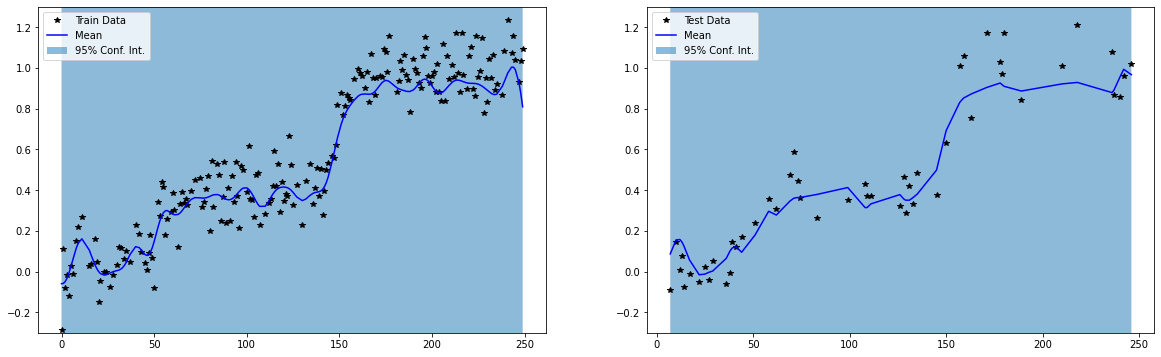

Iter 50/500 - Loss: -0.599   lengthscale: 9.900   noise: 0.009


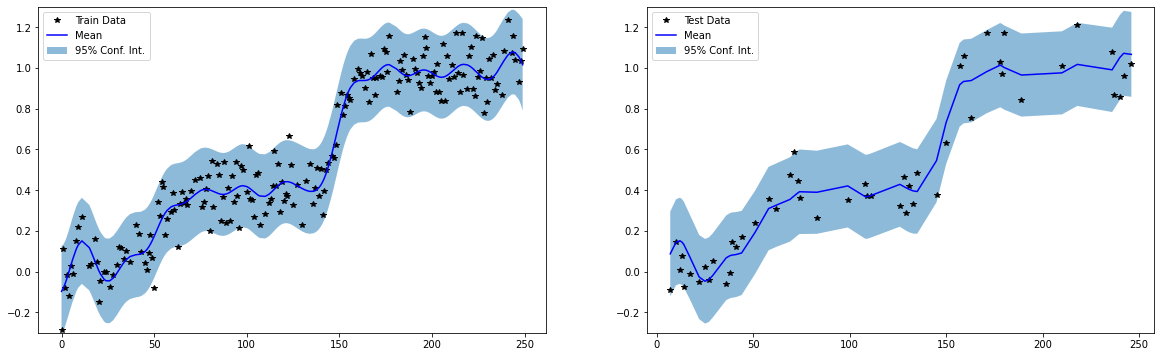

Iter 100/500 - Loss: -0.629   lengthscale: 13.119   noise: 0.011


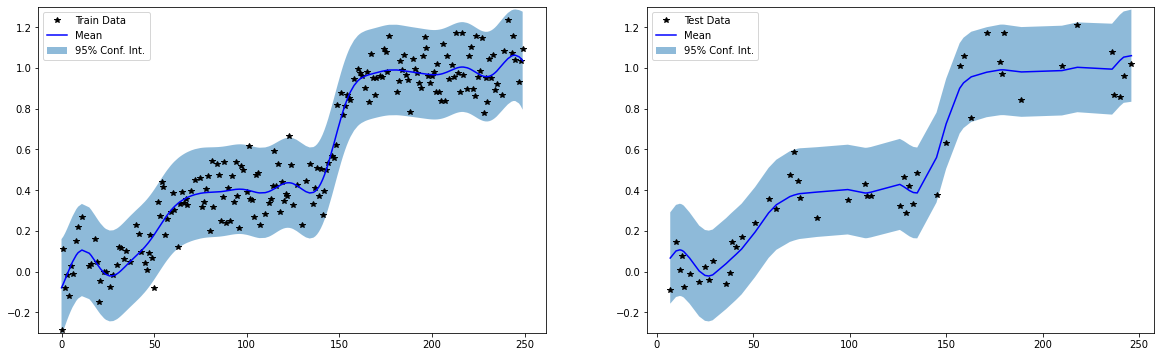

Iter 150/500 - Loss: -0.640   lengthscale: 15.344   noise: 0.012


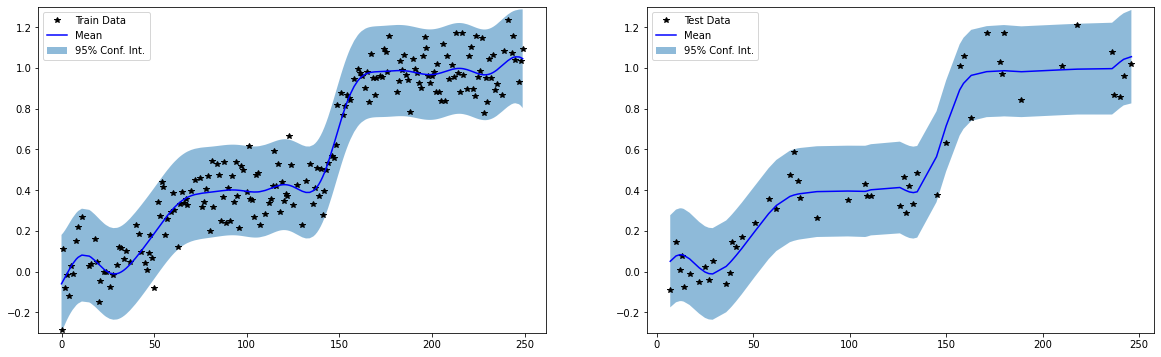

Iter 200/500 - Loss: -0.646   lengthscale: 17.271   noise: 0.012


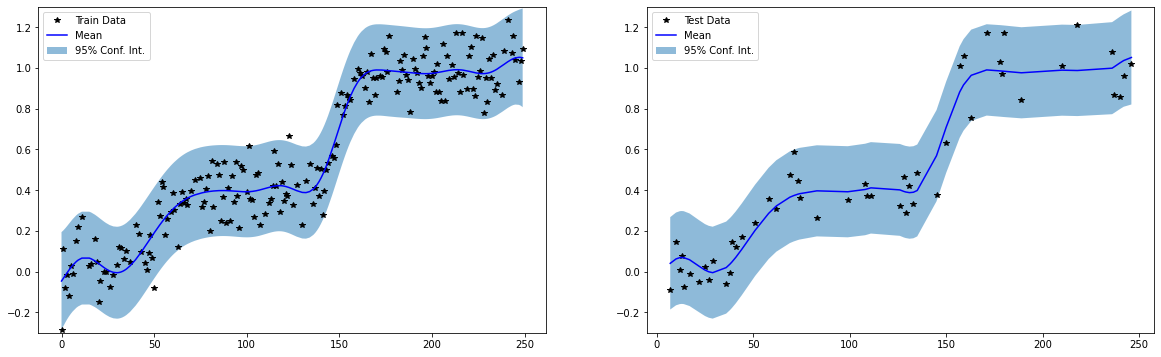

Iter 250/500 - Loss: -0.651   lengthscale: 18.987   noise: 0.012


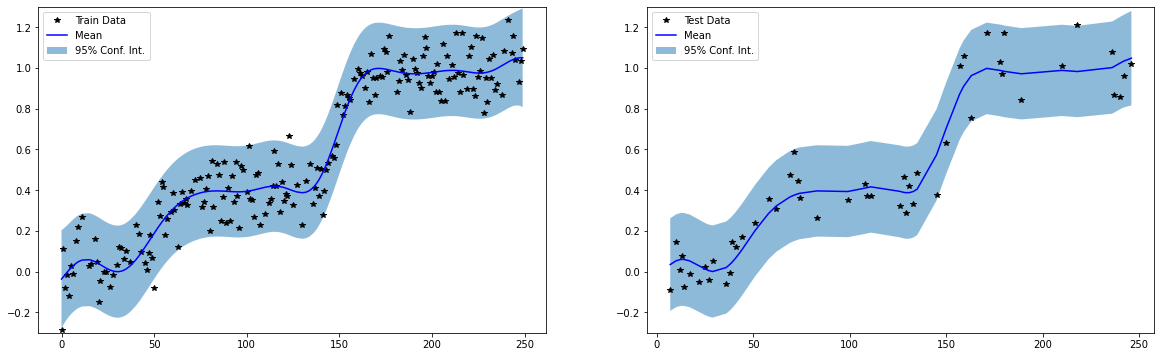

Iter 300/500 - Loss: -0.655   lengthscale: 20.588   noise: 0.012


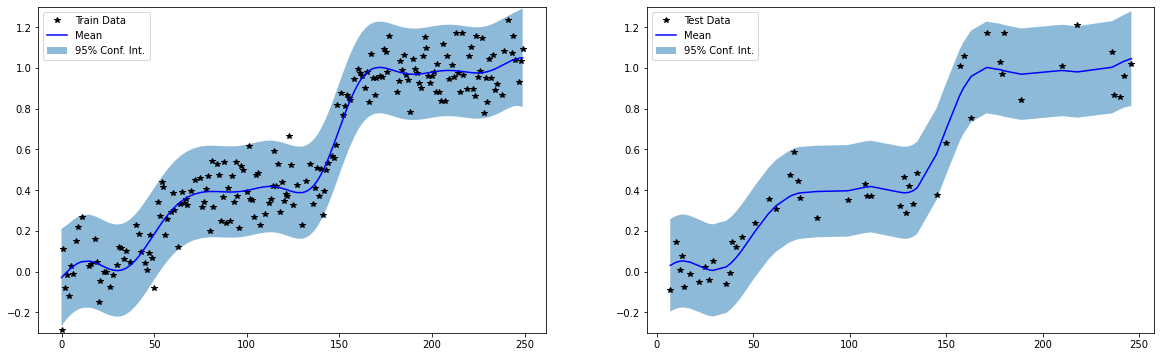

Iter 350/500 - Loss: -0.657   lengthscale: 21.994   noise: 0.012


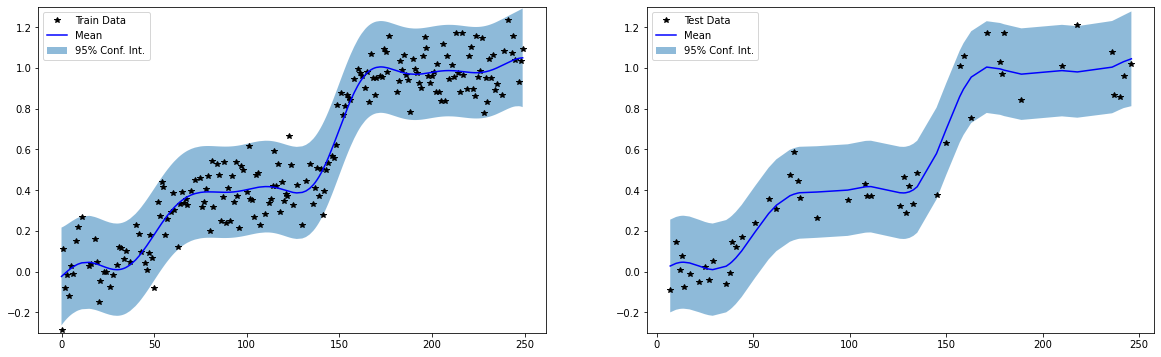

Iter 400/500 - Loss: -0.659   lengthscale: 23.127   noise: 0.012


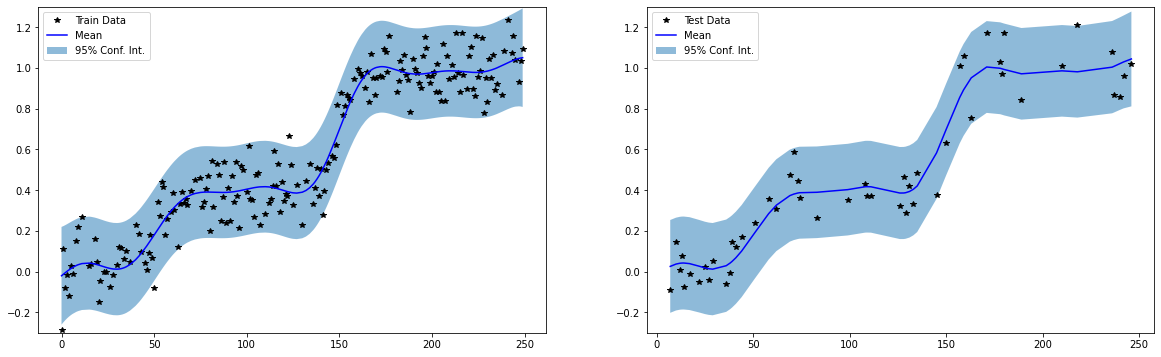

Iter 450/500 - Loss: -0.660   lengthscale: 23.953   noise: 0.012


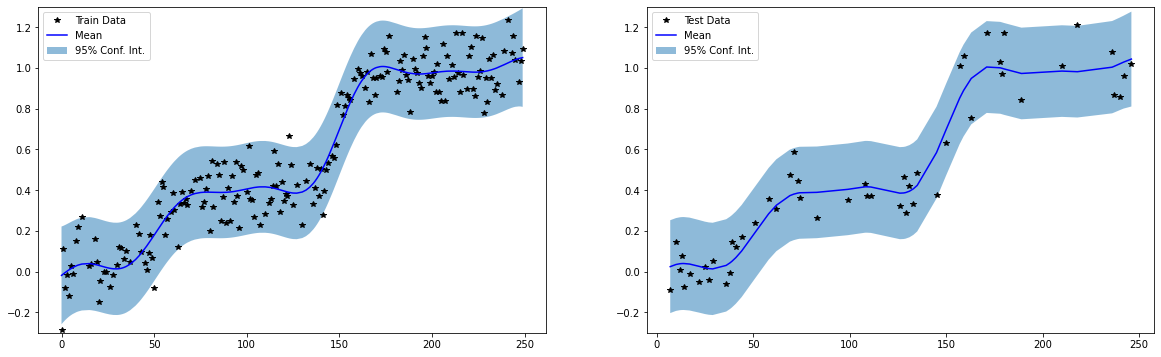

Iter 500/500 - Loss: -0.660   lengthscale: 24.505   noise: 0.012


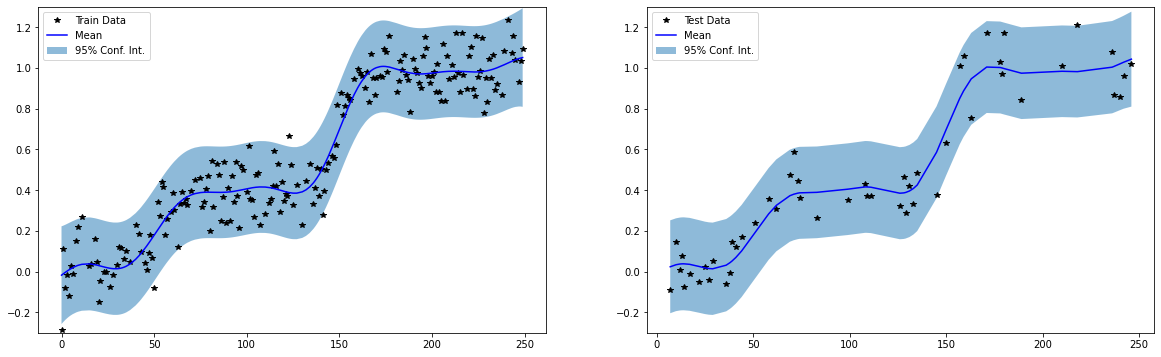

Train RMSE: 0.1060977354645729, Test RMSE: 0.10279148817062378


In [11]:
lengthscales = [5]

for l in lengthscales:
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood)
    
    #set lengthscale
    model.covar_module.base_kernel.lengthscale = l
    
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(501):
        if i == 0:
            print('BEFORE TRAINING')
            print('lengthscale: %.3f   noise: %.3f' % (
                model.covar_module.base_kernel.lengthscale.item(),
                model.likelihood.noise.item()
            ))
            train_mean, test_mean = plot_preds(model, likelihood)
            
        model.train()
        likelihood.train()
        
        optimizer.zero_grad()

        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        
        optimizer.step()

        if i % 50 == 0:
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                i , 500, loss.item(),
                model.covar_module.base_kernel.lengthscale.item(),
                model.likelihood.noise.item()
            ))
            
            train_mean, test_mean = plot_preds(model, likelihood)
            
            train_rmse = np.sqrt(np.mean((train_mean-train_y.numpy())**2))
            test_rmse = np.sqrt(np.mean((test_mean-test_y.numpy())**2))
            
            if i == 500:
                print('Train RMSE: {}, Test RMSE: {}'.format(train_rmse, test_rmse))